In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv('../../data/^gspc_raw_data.csv')
df = df[['Close', 'High', 'Low', 'Open']]
df = df.drop(index=[0, 1]).reset_index(drop=True)

In [5]:
df

,Close,High,Low,Open
0,1399.4200439453125,1455.219970703125,1397.4300537109375,1455.219970703125
1,1402.1099853515625,1413.27001953125,1377.6800537109375,1399.4200439453125
2,1403.449951171875,1411.9000244140625,1392.0999755859375,1402.1099853515625
3,1441.469970703125,1441.469970703125,1400.72998046875,1403.449951171875
4,1457.5999755859375,1464.3599853515625,1441.469970703125,1441.469970703125
...,...,...,...,...
6377,5886.5498046875,5906.64013671875,5845.02001953125,5854.14990234375
6378,5892.580078125,5906.5498046875,5872.10986328125,5896.740234375
6379,5916.93017578125,5924.2099609375,5865.16015625,5869.81982421875
6380,5958.3798828125,5958.6201171875,5907.35986328125,5929.08984375


In [3]:
def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 3])
    return np.array(X), np.array(y)

In [4]:
seq_length = 20
num_features = 4
X,y = create_sequence(df, seq_length)
train_size = int(len(df)*0.8)
X_train, X_test = X[0:train_size, :], X[train_size:, :]
y_train, y_test = y[0:train_size], y[train_size:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5105, 20, 4) (1257, 20, 4) (5105,) (1257,)


In [5]:
scalerX = MinMaxScaler(feature_range =(0,1))
scalery = MinMaxScaler(feature_range = (0,1))

x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
y_train = scalery.fit_transform(y_train.reshape(-1,1))
y_test = scalery.transform(y_test.reshape(-1,1))

In [6]:
x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
y_train = torch.from_numpy(y_train).float()
y_test = torch.from_numpy(y_test).float()
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

torch.Size([5105, 20, 4]) torch.Size([1257, 20, 4]) torch.Size([5105, 1]) torch.Size([1257, 1])


#define model

In [7]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUmodel, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])
    return out

In [8]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
  model.train()
  for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
      x_batch = x_train[i:i+batch_size]
      y_batch = y_train[i:i+batch_size]
      optimizer.zero_grad()
      loss = criterion(model(x_batch),y_batch)
      loss.backward()
      optimizer.step()
      print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [9]:
def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
  model = GRUmodel(input_size = num_features, hidden_size= neurons, output_size=1)
  criterion = nn.MSELoss()
  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)
  mse = criterion(y_test, y_pred)
  return mse, model

In [ ]:
best_mse = float('inf')
best_params = {}
neurons = [200,500,1000]
optimizers = ['adam','sgd']

mse_record = []

for n in neurons:
  for opt in optimizers:
    mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
    print(f'Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
    if mse < best_mse:
      best_mse = mse
      best_params = {'neurons': n, 'optimizer': opt}
      best_model = model
    mse_record.append({'neurons': n, 'optimizer': opt, 'mse': mse.item()})
mse_record = pd.DataFrame(mse_record)

Epoch [1/10], Loss: 0.0608
Epoch [1/10], Loss: 0.0717
Epoch [1/10], Loss: 0.0576
Epoch [1/10], Loss: 0.0596
Epoch [1/10], Loss: 0.0558
Epoch [1/10], Loss: 0.0449
Epoch [1/10], Loss: 0.0328
Epoch [1/10], Loss: 0.0236
Epoch [1/10], Loss: 0.0219
Epoch [1/10], Loss: 0.0080
Epoch [1/10], Loss: 0.0118
Epoch [1/10], Loss: 0.0107
Epoch [1/10], Loss: 0.0068
Epoch [1/10], Loss: 0.0021
Epoch [1/10], Loss: 0.0017
Epoch [1/10], Loss: 0.0032
Epoch [1/10], Loss: 0.0024
Epoch [1/10], Loss: 0.0025
Epoch [1/10], Loss: 0.0013
Epoch [1/10], Loss: 0.0004
Epoch [1/10], Loss: 0.0016
Epoch [1/10], Loss: 0.0012
Epoch [1/10], Loss: 0.0030
Epoch [1/10], Loss: 0.0009
Epoch [1/10], Loss: 0.0011
Epoch [1/10], Loss: 0.0029
Epoch [1/10], Loss: 0.0014
Epoch [1/10], Loss: 0.0002
Epoch [1/10], Loss: 0.0001
Epoch [1/10], Loss: 0.0000
Epoch [1/10], Loss: 0.0003
Epoch [1/10], Loss: 0.0006
Epoch [1/10], Loss: 0.0015
Epoch [1/10], Loss: 0.0030
Epoch [1/10], Loss: 0.0024
Epoch [1/10], Loss: 0.0018
Epoch [1/10], Loss: 0.0019
E

In [10]:
# Save the model
torch.save(best_model.state_dict(), 'gspc_best_model.pth')

NameError: name 'best_model' is not defined

In [11]:
# Load the model
best_params = {'neurons': 1000, 'optimizer': 'sgd'}
best_model = GRUmodel(input_size=num_features, hidden_size=best_params['neurons'], output_size=1)
best_model.load_state_dict(torch.load('gspc_best_model.pth'))

<All keys matched successfully>

MSE: 16373.58984375


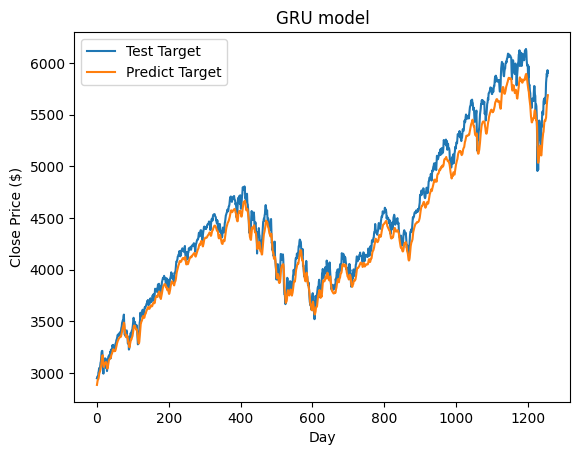

In [12]:

# print(f'Best MSE: {best_mse}')
# print(f'Best Params: {best_params}')

best_model.eval()
with torch.no_grad():
    y_pred = best_model(x_test)

# Inverse transform the predictions and actual values
y_pred = scalery.inverse_transform(y_pred.numpy())
y_test = scalery.inverse_transform(y_test.numpy())

mse = mean_squared_error(y_test, y_pred)
print(f'MSE: {mse}')

plt.title("GRU model")
plt.xlabel("Day")
plt.ylabel("Close Price ($)")
plt.plot(y_test, label="Test Target")
plt.plot(y_pred, label="Predict Target")
plt.legend()
plt.show()